In [1]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
from matplotlib import pyplot as plt

# Graph
<img src="/home/rico/Documents/thesis/paper/figures/sample_setup_ptn_map.png" width=400 height=400 />

In [2]:
g = ig.Graph(directed=True)

In [3]:
V_O = {f'RC{i+1}':i for i in range(6)}
V_O_attr = {
    'name': [e for e in V_O.keys()],
    'x': [3.5,2.5,3.5,0.5,0.5,1.5],
    'y': [3.5,3.5,2.5,1.5,0.5,0.5],
    'color': ['red','red','red','purple','purple','purple'],
    'type': 'res_node'
}
g.add_vertices(V_O.values(), V_O_attr)

In [4]:
V_P = {f'PT{i+1}':e for i,e in enumerate(range(6,12))}
V_P_attr = {
    'name': [e for e in V_P.keys()],
    'x': [1,2,3,3.5,3,3],
    'y': [1,2,1,3,3,3.5],
    'color': 'blue',
    'type': 'pt_node'
}
g.add_vertices(V_P.values(), V_P_attr)

In [5]:
V_D = {f'POI{i+1}':e for i,e in enumerate(range(12,15))}
V_D_attr = {
    'name': [e for e in V_D.keys()],
    'x': [2.75,2.75,3.25],
    'y': [2.75,3.25,2.75],
    'color': 'green',
    'type': 'poi_node'
}
g.add_vertices(V_D.values(), V_D_attr)

## PTN Edges

In [6]:
# Speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour
TRAIN_SPEED = 1000  # units per hour

In [7]:
def compute_dist_from_es(es: list):
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in E_WALK]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking

In [8]:
E_WALK = list(it.product(V_O.values(),V_P.values())) +\
         list(it.product(V_P.values(), V_D.values())) +\
         list(it.product(V_O.values(), V_D.values()))
distances_walk = compute_dist_from_es(E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}
g.add_edges(E_WALK, E_WALK_attr)

### PT

In [9]:
E_BUS = [
    (V_P['PT1'],V_P['PT2']),  # Bus_line_1
    (V_P['PT2'],V_P['PT1']),  # Bus_line_1
    (V_P['PT2'],V_P['PT5']),  # Bus_line_1
    (V_P['PT5'],V_P['PT2']),  # Bus_line_1
    (V_P['PT5'],V_P['PT4']),  # Bus_line_2
    (V_P['PT4'],V_P['PT5']),  # Bus_line_2
    (V_P['PT5'],V_P['PT6']),  # Bus_line_3
    (V_P['PT6'],V_P['PT5']),  # Bus_line_3
]
distances_bus = compute_dist_from_es(E_BUS)
E_BUS_attr = {
    'name': list(it.repeat(f'Bus_line_1',4)) +
            list(it.repeat(f'Bus_line_2',2)) +
            list(it.repeat(f'Bus_line_3',2)),
    'distance': distances_bus,
    'tt': (distances_bus * 1/BUS_SPEED) * 60,
    'weight': (distances_bus * 1/BUS_SPEED) * 60,
    'color': 'pink',
    'type': 'bus'
}
g.add_edges(E_BUS, E_BUS_attr)

In [10]:
E_TRAIN = [
    (V_P['PT1'],V_P['PT5']),  # Train_line_1
    (V_P['PT5'],V_P['PT3']),  # Train_line_1
    (V_P['PT3'],V_P['PT1']),  # Train_line_1
]
distances_train = compute_dist_from_es(E_TRAIN)
E_TRAIN_attr = {
    'name': list(it.repeat(f'Train_line_1',3)),
    'distance': distances_bus,
    'tt': (distances_train * 1/TRAIN_SPEED) * 60,
    'weight': (distances_train * 1/TRAIN_SPEED) * 60,
    'color': 'orange',
    'type': 'train'
}
g.add_edges(E_TRAIN, E_TRAIN_attr)

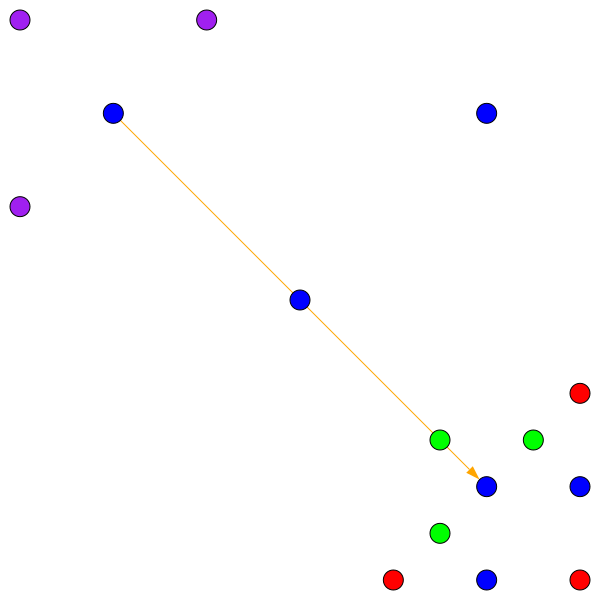

In [27]:
# fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g.subgraph_edges([80], delete_vertices=False))


In [46]:
g.es['active'] = 1

In [47]:
g.save('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/graph.gml')
g.save('/home/rico/Documents/thesis/experiments/base_data/graph_1.gml')

# Census Data

In [48]:
data = {
    'neighborhood': V_O_attr['name'],
    'n_inh': [1000,1000,1000,1200,800,1000],
    'n_purple': [100, 200, 200, 1000, 600, 1000],
    'n_red': [900, 800, 800, 200, 200, 0],
    'res_centroids': gpd.points_from_xy(V_O_attr['x'], V_O_attr['y'])
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC1,1000,100,900,POINT (3.50000 3.50000)
1,RC2,1000,200,800,POINT (2.50000 3.50000)
2,RC3,1000,200,800,POINT (3.50000 2.50000)
3,RC4,1200,1000,200,POINT (0.50000 1.50000)
4,RC5,800,600,200,POINT (0.50000 0.50000)
5,RC6,1000,1000,0,POINT (1.50000 0.50000)


In [49]:
gdf.to_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/census_data.geojson', driver='GeoJSON')
gdf.to_file('/home/rico/Documents/thesis/experiments/base_data/census_data_1.geojson', driver='GeoJSON')

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
